# Single Sample Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 18.08.2023

## 1. Setup

### 1.1 Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../../../nichecompass-reproducibility/utils")

In [ ]:
import os
import shutil
import warnings
from datetime import datetime

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import numpy as np
import pandas as pd
import pickle
import plottable
import scanpy as sc
import scib_metrics

from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

from benchmarking_utils import plot_metrics_table

### 1.2 Define Parameters

In [ ]:
spatial_key = "spatial"

In [ ]:
metric_cols_sample_integration = [
    "gcs", "mlami", "cas", "clisis", # spatial conservation
    "cari", "cnmi", "casw", "clisi", # biological conservation
    "nasw", # cluster separability
    "basw", "bgc", "blisi" # batch correction
]
metric_col_weights_sample_integration = [ # separate for each category (later multiplied with category_col_weights)
    (1/6), (1/6), (1/3), (1/3), # spatial conservation
    (1/4), (1/4), (1/4), (1/4), # biological conservation
    1.0, # cluster separability
    (1/3), (1/3), (1,3) # batch correction
]
metric_col_titles_sample_integration = [
    "Graph Connectivity Similarity",
    "Maximum Leiden Adjusted Mutual Info",
    "Cell Type Affinity Similarity",
    "Cell Type Local Inverse Simpson's Index Similarity",
    "Cell Type Adjusted Rand Index",
    "Cell Type Normalized Mutual Info",
    "Cell Type Average Silhouette Width",
    "Cell Type Local Inverse Simpson's Index",
    "Cluster Average Silhouette Width",
    "Batch Average Silhouette Width",
    "Batch Graph Connectivity",
    "Batch Local Inverse Simpson's Index"
]
metric_cols_single_sample = metric_cols_sample_integration[:-3]
metric_col_weights_single_sample = metric_col_weights_sample_integration[:-3]
metric_col_titles_single_sample = metric_col_titles_sample_integration[:-3]

category_cols_sample_integration = [
    "Spatial Conservation Score",
    "Biological Conservation Score",
    "Cluster Separability Score",
    "Batch Correction Score"]
category_col_weights_sample_integration = [
    1,
    1,
    1,
    1]
category_col_titles_sample_integration = [
    "Spatial Conservation Score (25%)",
    "Biological Conservation Score (25%)",
    "Cluster Separability Score (25%)",
    "Batch Correction Score (25%)"]
category_col_weights_single_sample = category_col_weights_sample_integration[:-1]
category_cols_single_sample = category_cols_sample_integration[:-1]
category_col_titles_single_sample = [
    "Spatial Conservation Score (33%)",
    "Biological Conservation Score (33%)",
    "Cluster Separability Score (33%)"]

### 1.3 Run Notebook Setup

In [ ]:
sc.set_figure_params(figsize=(6, 6))

In [ ]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [ ]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [ ]:
# Set mlflow tracking server (run it on the defined port)
mlflow.set_tracking_uri("http://localhost:8889")

### 1.4 Configure Paths and Directories

In [ ]:
data_folder_path = "../../datasets/srt_data/gold"
artifact_folder_path = f"../../artifacts"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"
benchmarking_folder_path = f"{artifact_folder_path}/single_sample_method_benchmarking"

## 2. Method Benchmarking

- Run all model notebooks in the ```notebooks/single_sample_method_benchmarking``` directory before continuing.

### 2.1 Retrieve NicheCompass Runs

#### 2.1.1 seqFISH Mouse Organogenesis

In [170]:
# Store NicheCompass GCN encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gcnconv"
datasets = [
    "seqfish_mouse_organogenesis_embryo2",
    "seqfish_mouse_organogenesis_subsample_50pct_embryo2",
    "seqfish_mouse_organogenesis_subsample_25pct_embryo2",
    "seqfish_mouse_organogenesis_subsample_10pct_embryo2",
    "seqfish_mouse_organogenesis_subsample_5pct_embryo2",
    "seqfish_mouse_organogenesis_subsample_1pct_embryo2",
]
timestamps = [
    "17082023_113817_1",
    "17082023_121306_1",
    "17082023_121306_1",
    "17082023_121309_1",
    "17082023_121309_1",
    "17082023_121309_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

In [ ]:
# Store NicheCompass GATv2 encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gatv2conv"
datasets = [
    "seqfish_mouse_organogenesis_embryo2",
    "seqfish_mouse_organogenesis_subsample_50pct_embryo2",
    "seqfish_mouse_organogenesis_subsample_25pct_embryo2",
    "seqfish_mouse_organogenesis_subsample_10pct_embryo2",
    "seqfish_mouse_organogenesis_subsample_5pct_embryo2",
    "seqfish_mouse_organogenesis_subsample_1pct_embryo2",
]
timestamps = [
    "16082023_153513_1",
    "16082023_201308_1",
    "16082023_201312_1",
    "16082023_201320_1",
    "16082023_201434_1",
    "16082023_202321_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

#### 2.1.2 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

In [164]:
# Store NicheCompass GCN encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gcnconv"
datasets = [
    "nanostring_cosmx_human_nsclc_batch5",
    "nanostring_cosmx_human_nsclc_subsample_50pct_batch5",
    "nanostring_cosmx_human_nsclc_subsample_25pct_batch5",
    "nanostring_cosmx_human_nsclc_subsample_10pct_batch5",
    "nanostring_cosmx_human_nsclc_subsample_5pct_batch5",
    "nanostring_cosmx_human_nsclc_subsample_1pct_batch5",
]
timestamps = [
    "16082023_174027_1",
    "16082023_174028_1",
    "16082023_174332_1",
    "17082023_100851_1",
    "17082023_101057_1",
    "16082023_154030_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

In [ ]:
# Store NicheCompass GATv2 encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gatv2conv"
datasets = [
    "nanostring_cosmx_human_nsclc_batch5",
    "nanostring_cosmx_human_nsclc_subsample_50pct_batch5",
    "nanostring_cosmx_human_nsclc_subsample_25pct_batch5",
    "nanostring_cosmx_human_nsclc_subsample_10pct_batch5",
    "nanostring_cosmx_human_nsclc_subsample_5pct_batch5",
    "nanostring_cosmx_human_nsclc_subsample_1pct_batch5",
]
timestamps = [
    "16082023_191755_1", # only contains 4 runs due to 2 day limit
    "16082023_203456_1",
    "18082023_100942_1",
    "17082023_100713_1",
    "16082023_203744_1",
    "16082023_203926_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

#### 2.1.4 Vizgen MERFISH Mouse Liver

In [ ]:
# Store NicheCompass GCN encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gcnconv"
datasets = [
    "vizgen_merfish_mouse_liver",
    "vizgen_merfish_mouse_liver_subsample_50pct",
    "vizgen_merfish_mouse_liver_subsample_25pct",
    "vizgen_merfish_mouse_liver_subsample_10pct",
    "vizgen_merfish_mouse_liver_subsample_5pct",
    "vizgen_merfish_mouse_liver_subsample_1pct",
]
timestamps = [
    "16082023_165031_1",
    "16082023_165038_1",
    "16082023_165031_1",
    "16082023_165031_1",
    "16082023_165031_1",
    "16082023_170911_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

In [ ]:
# Store NicheCompass GATv2 encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gatv2conv"
datasets = [
    "vizgen_merfish_mouse_liver",
    "vizgen_merfish_mouse_liver_subsample_50pct",
    "vizgen_merfish_mouse_liver_subsample_25pct",
    "vizgen_merfish_mouse_liver_subsample_10pct",
    "vizgen_merfish_mouse_liver_subsample_5pct",
    "vizgen_merfish_mouse_liver_subsample_1pct",
]
timestamps = [
    "",
    "",
    "",
    "",
    "",
    "16082023_204835_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

#### 2.1.5 Slide-seqV2 Mouse Hippocampus

In [ ]:
# Store NicheCompass GCN encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gcnconv"
datasets = [
    "slideseqv2_mouse_hippocampus",
    "slideseqv2_mouse_hippocampus_subsample_50pct",
    "slideseqv2_mouse_hippocampus_subsample_25pct",
    "slideseqv2_mouse_hippocampus_subsample_10pct",
    "slideseqv2_mouse_hippocampus_subsample_5pct",
    "slideseqv2_mouse_hippocampus_subsample_1pct",
]
timestamps = [
    "16082023_205838_1",
    "16082023_210004_1",
    "16082023_210005_1",
    "16082023_210304_1",
    "16082023_211128_1",
    "16082023_211128_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

In [ ]:
# Store NicheCompass GATv2 encoder results in benchmarking folder
task = "single_sample_method_benchmarking"
conv_layer_encoder = "gatv2cov"
datasets = [
    "slideseqv2_mouse_hippocampus",
    "slideseqv2_mouse_hippocampus_subsample_50pct",
    "slideseqv2_mouse_hippocampus_subsample_25pct",
    "slideseqv2_mouse_hippocampus_subsample_10pct",
    "slideseqv2_mouse_hippocampus_subsample_5pct",
    "slideseqv2_mouse_hippocampus_subsample_1pct",
]
timestamps = [
    "17082023_104409_1",
    "18082023_095235_1",
    "17082023_110554_1",
    "16082023_212040_1",
    "16082023_212145_1",
    "16082023_212338_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

### 2.1 Create Benchmarking Metrics Plots & Run Time Plots

#### 2.1.1 seqFISH Mouse Organogenesis

In [171]:
datasets = ["seqfish_mouse_organogenesis_embryo2",
            "seqfish_mouse_organogenesis_subsample_50pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_25pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_10pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_5pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_1pct_embryo2"]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "deeplinc",
          "graphst",
          "sagenet",
          "scvi",
          "expimap"]

In [172]:
summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
        #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
        #training_durations = []
        #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
        #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
        #benchmark_df["run_time"] = training_durations
        #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
        #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
        benchmark_df["model"] = model
        benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
        benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[4:8]], weights=metric_col_weights_single_sample[4:8], axis=1)
        benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[8:9]], weights=metric_col_weights_single_sample[8:9], axis=1)
        benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
        summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
 
# Reformat for plot
summary_df.replace({"nichecompass_gcnconv": "NicheCompass GCN",
                    "nichecompass_gatv2conv": "NicheCompass GATv2",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

In [173]:
summary_df["model"].value_counts()

NicheCompass GCN      48
NicheCompass GATv2    48
DeepLinc              48
GraphST               48
SageNet               48
scVI                  48
expiMap               48
Name: model, dtype: int64

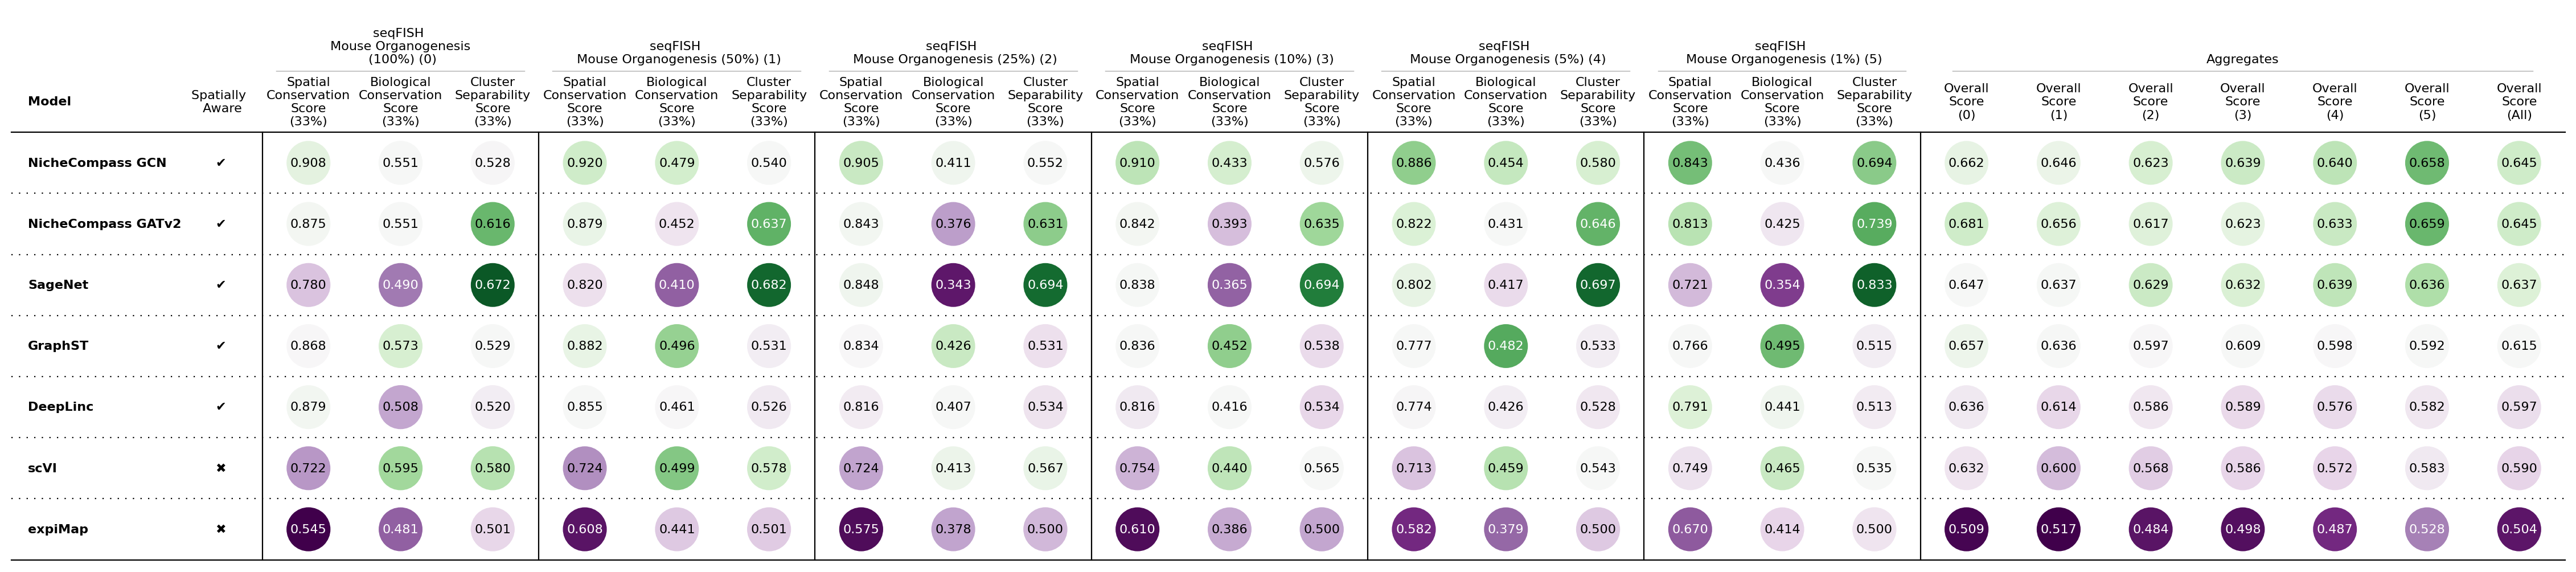

In [178]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.,
    group_col="dataset",
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.1, # 0.8,
    plot_width=36, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_seqfish_mouse_organogenesis.png")

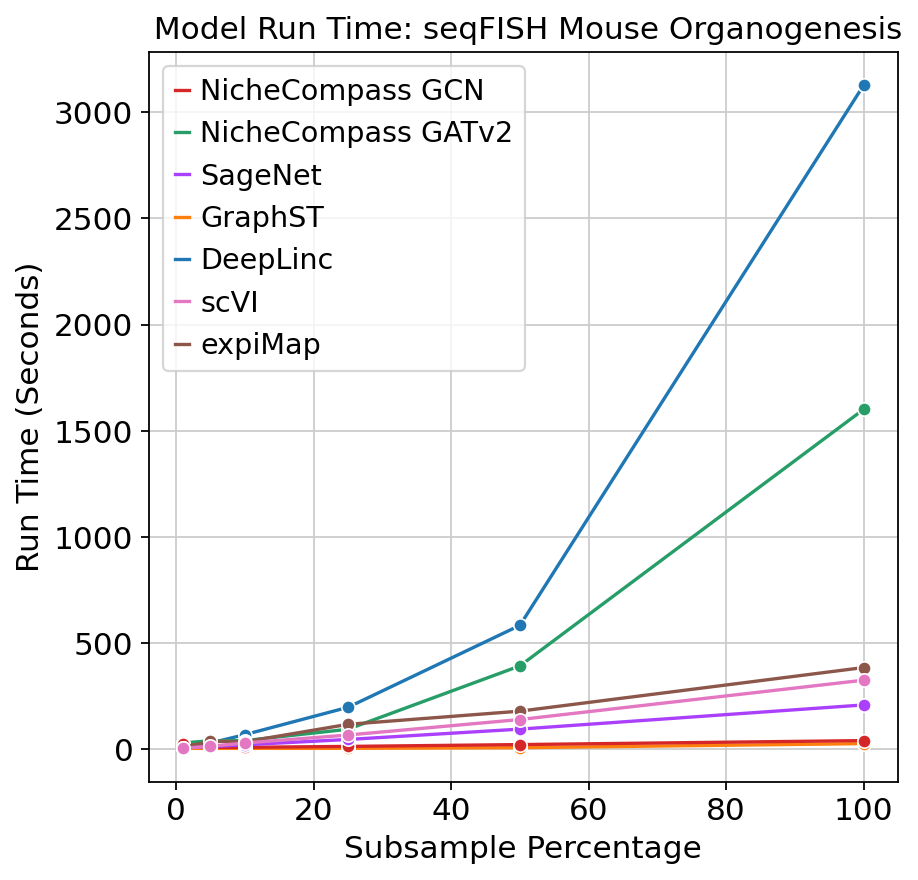

In [190]:
run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()

def create_dataset_share_col(row):
    if row["dataset"] == "seqfish_mouse_organogenesis_embryo2":
        return 100
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_50pct_embryo2":    
        return 50
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_25pct_embryo2":    
        return 25
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_10pct_embryo2":    
        return 10
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_5pct_embryo2":    
        return 5
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_1pct_embryo2":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
sns.lineplot(data=run_time_mean_df, x="dataset_share", y="run_time", hue="model", marker='o')
plt.title(" Model Run Time: seqFISH Mouse Organogenesis")
plt.ylabel("Run Time (Seconds)")
plt.xlabel("Subsample Percentage")
legend = plt.gca().get_legend()
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0, 6, 5]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_seqfish_mouse_organogenesis.png")
plt.show()

#### 2.1.2 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

In [ ]:
datasets = ["nanostring_cosmx_human_nsclc_batch5",
            "nanostring_cosmx_human_nsclc_subsample_50pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_25pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_10pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_5pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_1pct_batch5"]
models = [#"nichecompass_gcnconv",
          #"nichecompass_gatv2conv",
          #"deeplinc",
          "graphst",
          #"sagenet",
          "scvi",
          #"expimap"
]

In [ ]:
summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[4:8]], weights=metric_col_weights_single_sample[4:8], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[8:9]], weights=metric_col_weights_single_sample[8:9], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gcnconv": "NicheCompass GCN",
                    "nichecompass_gatv2conv": "NicheCompass GATv2",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

In [ ]:
summary_df["model"].value_counts()

In [ ]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.,
    group_col="dataset",
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.2, # 0.8,
    plot_width=36, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_results_{dataset}.png")

In [ ]:
run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()

def create_dataset_share_col(row):
    if row["dataset"] == "nanostring_cosmx_human_nsclc_batch5":
        return 100
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_50pct_batch5":    
        return 50
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_25pct_batch5":    
        return 25
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_10pct_batch5":    
        return 10
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_5pct_batch5":    
        return 5
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_1pct_batch5":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
sns.lineplot(data=run_time_mean_df, x="dataset_share", y="run_time", hue="model", marker='o')
plt.title("nanoString CosMx Human NSCLC Model Run Times")
plt.ylabel("Run Time (Seconds)")
plt.xlabel("Subsample Percentage")
plt.legend()
plt.show()

#### 2.1.3 Vizgen MERFISH Mouse Liver

In [ ]:
datasets = ["vizgen_merfish_mouse_liver",
            "vizgen_merfish_mouse_liver_subsample_50pct",
            "vizgen_merfish_mouse_liver_subsample_25pct",
            "vizgen_merfish_mouse_liver_subsample_10pct",
            "vizgen_merfish_mouse_liver_subsample_5pct",
            "vizgen_merfish_mouse_liver_subsample_1pct"]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "deeplinc",
          "graphst",
          "sagenet",
          "scvi",
          "expimap"]

In [ ]:
summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[4:8]], weights=metric_col_weights_single_sample[4:8], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[8:9]], weights=metric_col_weights_single_sample[8:9], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gcnconv": "NicheCompass GCN",
                    "nichecompass_gatv2conv": "NicheCompass GATv2",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

In [ ]:
summary_df["model"].value_counts()

In [ ]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.,
    group_col="dataset",
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.2, # 0.8,
    plot_width=36, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_results_{dataset}.png")

#### 2.1.4 Slide-seqV2 Mouse Hippocampus

In [ ]:
datasets = ["slideseqv2_mouse_hippocampus",
            "slideseqv2_mouse_hippocampus_subsample_50pct",
            "slideseqv2_mouse_hippocampus_subsample_25pct",
            "slideseqv2_mouse_hippocampus_subsample_10pct",
            "slideseqv2_mouse_hippocampus_subsample_5pct",
            "slideseqv2_mouse_hippocampus_subsample_1pct"]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "deeplinc",
          "graphst",
          "sagenet",
          "scvi",
          "expimap"]

In [ ]:
summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[4:8]], weights=metric_col_weights_single_sample[4:8], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[8:9]], weights=metric_col_weights_single_sample[8:9], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gcnconv": "NicheCompass GCN",
                    "nichecompass_gatv2conv": "NicheCompass GATv2",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

In [ ]:
summary_df["model"].value_counts()

In [ ]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.,
    group_col="dataset",
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.2, # 0.8,
    plot_width=36, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_results_{dataset}.png")

In [ ]:
summary_df["model"].value_counts()

In [ ]:
run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()

def create_dataset_share_col(row):
    if row["dataset"] == "slideseqv2_mouse_hippocampus":
        return 100
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_50pct":    
        return 50
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_25pct":    
        return 25
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_10pct":    
        return 10
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_5pct":    
        return 5
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
sns.lineplot(data=run_time_mean_df, x="dataset_share", y="run_time", hue="model", marker='o')
plt.title("nanoString CosMx Human NSCLC Model Run Times")
plt.ylabel("Run Time (Seconds)")
plt.xlabel("Subsample Percentage")
plt.legend()
plt.show()

### 2.1 Latent Space Comparison

#### 2.1.2 Visualize Results

##### 2.1.2.1 seqFISH Mouse Organogenesis

In [191]:
compute_latent_space_comparison(
    dataset="seqfish_mouse_organogenesis_embryo2",
    cell_type_colors=color_utils.seqfish_mouse_organogenesis_cell_type_colors,
    cell_type_groups=None,
    n_neighbors=12,
    run_number=5,
    spot_size=0.03)

NameError: name 'compute_latent_space_comparison' is not defined

In [ ]:
compute_latent_space_comparison(dataset="seqfish_mouse_organogenesis_embryo2",
                                cell_type_colors=seqfish_mouse_organogenesis_embryo2_cell_type_colors,
                                cell_type_groups="Mixed mesenchymal mesoderm", # "Gut tube",
                                n_neighbors=12,
                                run_number=5,
                                spot_size=0.03)

##### 2.1.2.2 MERFISH Mouse Liver

In [ ]:
# DeepLinc did not work on this dataset
compute_latent_space_comparison(dataset="vizgen_merfish_mouse_liver",
                                cell_type_colors=vizgen_merfish_mouse_liver_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                included_models=["NicheCompass",
                                                 "expiMap",
                                                 "scVI"],
                                spot_size=20.0)

In [ ]:
# DeepLinc did not work on this dataset
compute_latent_space_comparison(dataset="vizgen_merfish_mouse_liver_sample",
                                cell_type_colors=vizgen_merfish_mouse_liver_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                included_models=["NicheCompass",
                                                 "GraphST",
                                                 "SageNet",
                                                 "expiMap",
                                                 "scVI"],
                                spot_size=20.0)

##### 2.1.2.3 STARmap PLUS Mouse CNS

In [ ]:
compute_latent_space_comparison(dataset="starmap_plus_mouse_cns",
                                cell_type_colors=starmap_pluse_mouse_cns_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                included_models=["NicheCompass",
                                                 "expiMap",
                                                 "scVI"],
                                spot_size=0.2)

In [ ]:
compute_latent_space_comparison(dataset="starmap_plus_mouse_cns_sample",
                                cell_type_colors=starmap_pluse_mouse_cns_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                spot_size=0.2)

##### 2.1.2.4 NanoString CosMx Human NSCLC

In [ ]:
compute_latent_space_comparison(dataset="nanostring_cosmx_human_nsclc",
                                cell_type_colors=nanostring_cosmx_human_nsclc_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                included_models=["NicheCompass",
                                                 "expiMap",
                                                 "scVI"],
                                spot_size=100.0)

In [ ]:
compute_latent_space_comparison(dataset="nanostring_cosmx_human_nsclc_sample",
                                cell_type_colors=nanostring_cosmx_human_nsclc_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                spot_size=100.0)